### Do large-scale VLS with active learning using the best model

The best model:

 - `batchsize=20_000`
 - `num_iterations=100`
 - `regime=MeanRank`

In [1]:
from utils import InMemoryDatabase, IterativeDatabase
from pathlib import Path
import numpy as np
import pandas as pd
from functools import lru_cache

In [11]:
@lru_cache(maxsize=1)
def read_scores(db):
    rv = []
    for f in sorted(db.files):
        df = pd.read_parquet(f, engine="pyarrow")["dockscore"]
        rv.append(df)
    return pd.concat(rv)


def create_csv_for(dataset: str):
    found = 0
    db = IterativeDatabase(dataset, force=False)
    top_P = 0.05 / 100  # 0.05%
    batchsize = 20_000
    all_scores = read_scores(db)

    N = all_scores.shape[0]
    top_N = int(N * top_P)
    random_found_per_step = int(batchsize * top_P)
    top_idx = np.argpartition(-all_scores, -top_N)[-top_N:]
    random_found = 0

    rv = pd.DataFrame(
        columns=[
            "iteration_num",
            "N_screened",
            "percentage_screened",
            "mean_score",
            "median_score",
            "min_score",
            "shared_with_top_N",
            "N_found_by_now",
            "N_found_if_random",
            "percentage_found",
        ]
    )

    for i, arr in enumerate(
        [
            np.load(fin)
            for fin in sorted(
                [
                    f
                    for f in Path(f"../active_learning/{dataset}/molecules").iterdir()
                    if f.stem.replace(dataset, "")[1:].isnumeric()
                ]
            )
        ]
    ):
        scores = all_scores.loc[arr]

        shared = len(set(np.intersect1d(np.unique(arr), np.unique(top_idx))))
        random_found += random_found_per_step
        found += shared
        p_found = found / top_N * 100
        N_screened = batchsize * i
        lib_P = N_screened / N * 100

        to_append = {
            "iteration_num": i,
            "N_screened": N_screened,
            "percentage_screened": lib_P,
            "mean_score": scores.mean(),
            "min_score": scores.min(),
            "median_score": scores.median(),
            "shared_with_top_N": shared,
            "N_found_by_now": found,
            "N_found_if_random": random_found,
            "percentage_found": p_found,
        }

        rv.loc[i] = to_append
    rv.to_csv(f"../active_learning/{dataset}_active_learning_results.csv")

In [12]:
for dataset in ('D4', 'AmpC'):
    create_csv_for(dataset)

In [13]:
df = pd.DataFrame()
for dataset in ("D4", "AmpC"):
    tmp = pd.read_csv(
        f"../active_learning/{dataset}_active_learning_results.csv",
        index_col="iteration_num",
    )
    tmp["dataset"] = dataset
    df = pd.concat([df, tmp])
for col in df.columns:
    if "Unnamed" in col:
        df = df.drop(col, axis=1)
raw_data = df.copy(deep=True)

In [14]:
df

,N_screened,percentage_screened,mean_score,median_score,min_score,shared_with_top_N,N_found_by_now,N_found_if_random,percentage_found,dataset
iteration_num,,,,,,,,,,
0,0,0.000000,-28.389885,-29.185,-66.73,8,8,10,0.013765,D4
1,20000,0.017206,-28.044563,-29.405,-64.66,13,21,20,0.036132,D4
2,40000,0.034411,-44.311375,-45.450,-66.05,223,244,30,0.419821,D4
3,60000,0.051617,-44.867902,-45.980,-67.93,226,470,40,0.808672,D4
4,80000,0.068822,-43.897363,-45.045,-68.39,189,659,50,1.133861,D4
...,...,...,...,...,...,...,...,...,...,...
95,1900000,1.974760,-49.166060,-49.380,-92.77,320,31923,960,66.358326,AmpC
96,1920000,1.995547,-48.886088,-48.850,-88.63,269,32192,970,66.917496,AmpC
97,1940000,2.016334,-47.908513,-46.080,-87.91,196,32388,980,67.324922,AmpC


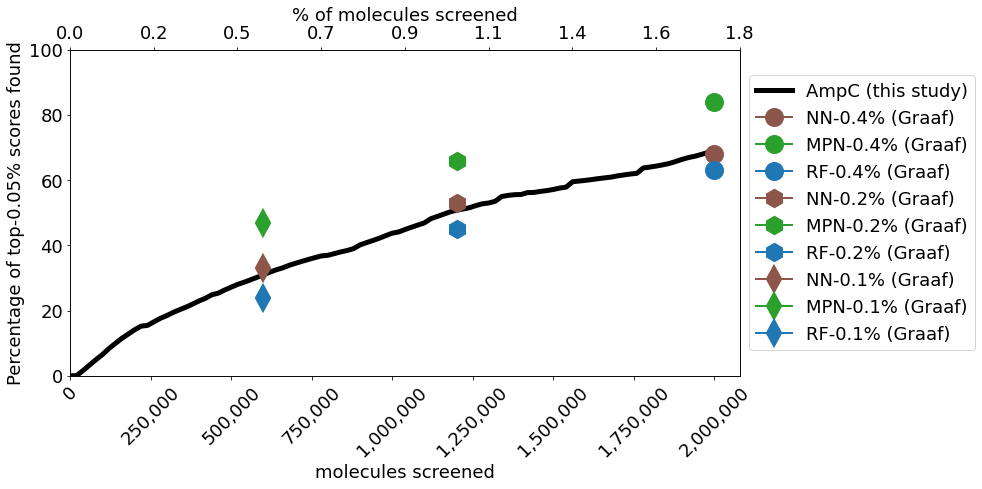

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib

df = raw_data.query("dataset == 'AmpC'")
df_2 = raw_data.query('dataset == "D4"')

matplotlib.rcParams.update({"font.size": 18})

# Create the figure and axis objects
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot N_found on the primary Y-axis and n_screened on the primary X-axis
ax1.plot(
    df["N_screened"],
    df["percentage_found"],
    color="k",
    label="AmpC (this study)",
    linewidth=5,
)
# ax1.plot(
#     df_2["N_screened"],
#     df_2["percentage_found"],
#     color="k",
#     linestyle=":",
#     label="D4 (this study)",
#     linewidth=5,
# )
ax1.set_xlabel("molecules screened")
ax1.set_ylabel(r"Percentage of top-0.05% scores found", color="k")

# change y limit
ax1.set_ylim(0, 100)
ax1.set_xlim(0, None)

# change format of x axis
def format_x_axis_labels(x, pos):
    return "{:,.0f}".format(x)  # Format with commas for thousands


ax1.xaxis.set_major_formatter(FuncFormatter(format_x_axis_labels))
ax1.tick_params(axis="x", rotation=45)

# Create a secondary X-axis at the top
ax2 = ax1.twiny()

# Calculate n_screened divided by 2 million
ax2_ticks = np.arange(0, 2_000_000, 225_000) / 99_500_000 * 100
ax2.set_xticks(ax2_ticks)
ax2.set_xticklabels([f"{n:2.1f}" for n in ax2_ticks])

# Plot the secondary X-axis
ax2.set_xlim(
    (ax2_ticks.min(), ax2_ticks.max())
)  # Make sure the secondary X-axis has the same limits as the primary
ax2.set_xlabel(r"% of molecules screened")

# add values from the Graaf et al paper
deGraaf = {
    "NN-0.4% (Graaf)": (2_000_000, 0.68),
    "MPN-0.4% (Graaf)": (2_000_000, 0.84),
    "RF-0.4% (Graaf)": (2_000_000, 0.63),
    # ---
    "NN-0.2% (Graaf)": (1_200_000, 0.53),
    "MPN-0.2% (Graaf)": (1_200_000, 0.66),
    "RF-0.2% (Graaf)": (1_200_000, 0.45),
    # ---
    "NN-0.1% (Graaf)": (600_000, 0.33),
    "MPN-0.1% (Graaf)": (600_000, 0.47),
    "RF-0.1% (Graaf)": (600_000, 0.24),
}

colors = {"NN": "tab:brown", "MPN": "tab:green", "RF": "tab:blue"}
markers = {r"0.1%": "d", r"0.2%": "h", r"0.4%": "o"}

for label, (n_screened, p_found) in deGraaf.items():
    name, percentage = label.split("-")
    color = colors[name]
    marker = markers[percentage.split()[0]]
    p_found *= 100
    ax1.plot(
        n_screened,
        p_found,
        label=label,
        marker=marker,
        color=color,
        markersize=15,
        linewidth=2,
        markeredgewidth=4,
    )

# add legend
lines, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(lines, labels, loc="center left", bbox_to_anchor=(1, 0.5))

# Display the plot
# plt.savefig(
#     "../figures/figure_5_comparison.png",
#     bbox_extra_artists=(lgd,),
#     bbox_inches="tight",
#     dpi=300,
# )

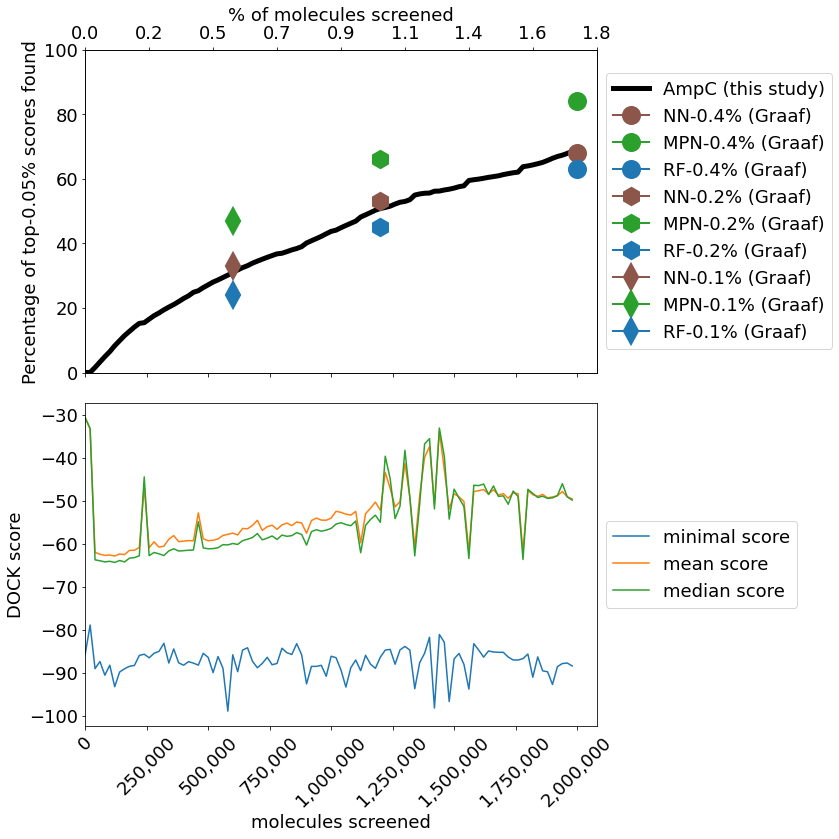

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib

df = raw_data.query("dataset == 'AmpC'")
df_2 = raw_data.query('dataset == "D4"')

matplotlib.rcParams.update({"font.size": 18})

# Create the figure and axis objects
fig, axs = plt.subplots(
    nrows=2,
    figsize=(12, 12),
    sharex=True,
)
ax1 = axs[0]
ax_scores = axs[1]

# Plot N_found on the primary Y-axis and n_screened on the primary X-axis
ax1.plot(
    df["N_screened"],
    df["percentage_found"],
    color="k",
    label="AmpC (this study)",
    linewidth=5,
)
# ax1.plot(
#     df_2["N_screened"],
#     df_2["percentage_found"],
#     color="k",
#     linestyle=":",
#     label="D4 (this study)",
#     linewidth=5,
# )
# ax1.set_xlabel("molecules screened")
ax1.set_ylabel(r"Percentage of top-0.05% scores found", color="k")

# change y limit
ax1.set_ylim(0, 100)
ax1.set_xlim(0, None)

# Create a secondary X-axis at the top
ax2 = ax1.twiny()

# Calculate n_screened divided by 2 million
ax2_ticks = np.arange(0, 2_000_000, 225_000) / 99_500_000 * 100
ax2.set_xticks(ax2_ticks)
ax2.set_xticklabels([f"{n:2.1f}" for n in ax2_ticks])

# Plot the secondary X-axis
ax2.set_xlim(
    (ax2_ticks.min(), ax2_ticks.max())
)  # Make sure the secondary X-axis has the same limits as the primary
ax2.set_xlabel(r"% of molecules screened")

# add values from the Graaf et al paper
deGraaf = {
    "NN-0.4% (Graaf)": (2_000_000, 0.68),
    "MPN-0.4% (Graaf)": (2_000_000, 0.84),
    "RF-0.4% (Graaf)": (2_000_000, 0.63),
    # ---
    "NN-0.2% (Graaf)": (1_200_000, 0.53),
    "MPN-0.2% (Graaf)": (1_200_000, 0.66),
    "RF-0.2% (Graaf)": (1_200_000, 0.45),
    # ---
    "NN-0.1% (Graaf)": (600_000, 0.33),
    "MPN-0.1% (Graaf)": (600_000, 0.47),
    "RF-0.1% (Graaf)": (600_000, 0.24),
}

colors = {"NN": "tab:brown", "MPN": "tab:green", "RF": "tab:blue"}
markers = {r"0.1%": "d", r"0.2%": "h", r"0.4%": "o"}

for label, (n_screened, p_found) in deGraaf.items():
    name, percentage = label.split("-")
    color = colors[name]
    marker = markers[percentage.split()[0]]
    p_found *= 100
    ax1.plot(
        n_screened,
        p_found,
        label=label,
        marker=marker,
        color=color,
        markersize=15,
        linewidth=2,
        markeredgewidth=4,
    )

# add legend
lines, labels = ax1.get_legend_handles_labels()
lgd = ax1.legend(lines, labels, loc="center left", bbox_to_anchor=(1, 0.5))

# change format of x axis
def format_x_axis_labels(x, pos):
    return "{:,.0f}".format(x)  # Format with commas for thousands


ax_scores.xaxis.set_major_formatter(FuncFormatter(format_x_axis_labels))
ax_scores.tick_params(axis="x", rotation=45)


# plot docking scores
ax_scores.plot(df.N_screened, df.min_score, label="minimal score")
ax_scores.plot(df.N_screened, df.mean_score, label="mean score")
ax_scores.plot(df.N_screened, df.median_score, label="median score")

lines, labels = ax_scores.get_legend_handles_labels()
lgd_scores = ax_scores.legend(lines, labels, loc="center left", bbox_to_anchor=(1, 0.5))
ax_scores.set_xlabel("molecules screened")
ax_scores.set_ylabel("DOCK score")
plt.tight_layout()

# Display the plot
plt.savefig(
    "../figures/figure_5_comparison.png",
    bbox_extra_artists=(lgd,),
    bbox_inches="tight",
    dpi=300,
)